In [1]:
import random
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, List, Optional

import cv2
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from transformers import ViTForImageClassification, ViTImageProcessor

c:\Users\Playdata\Downloads\Hecto\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Settings

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
MODEL_ID = "prithivMLmods/Deep-Fake-Detector-v2-Model"
TEST_DIR = Path("./open/test_data")  # test 데이터 경로

# Submission
OUTPUT_DIR = Path("./output")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)  # output 폴더 없으면 생성

OUT_CSV = OUTPUT_DIR / "v6_optimized_topk3_t09.csv"  # 🔥 최적화 버전

In [26]:
IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".jfif"}
VIDEO_EXTS = {".mp4", ".mov"}

TARGET_SIZE = (224, 224)
NUM_FRAMES = 20  # 비디오 샘플링 프레임 수 증가 (품질 기반 필터링 적용)

# Face detection & aggregation settings
FACE_DETECT_DNN = True       # DNN 기반 얼굴 검출 사용 (Res10 SSD)
FACE_MARGIN = 0.15           # 얼굴 박스 여백 비율 (약간 감소)
AGGREGATION_METHOD = "topk_mean"  # 비디오 레벨 집계: "topk_mean" | "max" | "mean" | "median"
TOPK = 3                     # 🔥 기본 top-k=3 (강한 Fake 신호만 선택)
QUALITY_FILTER = True        # 프레임 품질 기반 필터링
QUALITY_THRESHOLD = 30.0     # 🔥 블러 임계값 = 30.0 (너무 완화하지 않음, Real 노이즈 방지)

# Temperature scaling (softmax 온도)
TEMP = 0.9  # 🔥 0.9로 샤프하게 (logit 스케일링 + clip으로 순위 정리)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")

Device: cpu


# Utils

In [5]:
def uniform_frame_indices(total_frames: int, num_frames: int) -> np.ndarray:
    """비디오 프레임을 균등하게 샘플링"""
    if total_frames <= 0:
        return np.array([], dtype=int)
    if total_frames <= num_frames:
        return np.arange(total_frames, dtype=int)
    return np.linspace(0, total_frames - 1, num_frames, dtype=int)

def get_full_frame_padded(pil_img: Image.Image, target_size=(224, 224)) -> Image.Image:
    """전체 이미지를 비율 유지하며 정사각형 패딩 처리"""
    img = pil_img.convert("RGB")
    img.thumbnail(target_size, Image.BICUBIC)
    new_img = Image.new("RGB", target_size, (0, 0, 0))
    new_img.paste(img, ((target_size[0] - img.size[0]) // 2,
                        (target_size[1] - img.size[1]) // 2))
    return new_img

def read_rgb_frames(file_path: Path, num_frames: int = NUM_FRAMES) -> List[np.ndarray]:
    """이미지 또는 비디오에서 RGB 프레임 추출"""
    ext = file_path.suffix.lower()
    
    # 이미지 파일
    if ext in IMAGE_EXTS:
        try:
            img = Image.open(file_path).convert("RGB")
            return [np.array(img)]
        except Exception:
            return []
    
    # 비디오 파일
    if ext in VIDEO_EXTS:
        cap = cv2.VideoCapture(str(file_path))
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        if total <= 0:
            cap.release()
            return []
        
        frame_indices = uniform_frame_indices(total, num_frames)
        frames = []
        
        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
            ret, frame = cap.read()
            if not ret:
                continue
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        
        cap.release()
        return frames
    
    return []

# ---- DNN Face Detection ----

# DNN 모델 로드 (전역 변수로 한 번만 로드)
_dnn_face_net = None

def _get_dnn_face_detector():
    """DNN 얼굴 검출기 싱글톤"""
    global _dnn_face_net
    if _dnn_face_net is None:
        try:
            # OpenCV DNN Res10 SSD 모델
            model_file = cv2.data.haarcascades.replace('haarcascades', 'dnn') + 'res10_300x300_ssd_iter_140000.caffemodel'
            config_file = cv2.data.haarcascades.replace('haarcascades', 'dnn') + 'deploy.prototxt'
            
            # 모델 파일이 없으면 온라인에서 다운로드 필요
            # 여기서는 fallback으로 Haar Cascade 사용
            import os
            if not (os.path.exists(model_file) and os.path.exists(config_file)):
                return None
            
            _dnn_face_net = cv2.dnn.readNetFromCaffe(config_file, model_file)
        except Exception:
            return None
    return _dnn_face_net

def _detect_largest_face_bbox_dnn(rgb: np.ndarray) -> Optional[tuple]:
    """DNN 기반 얼굴 검출. Fallback으로 Haar Cascade 사용."""
    h, w = rgb.shape[:2]
    
    # DNN 시도
    net = _get_dnn_face_detector()
    if net is not None:
        try:
            blob = cv2.dnn.blobFromImage(rgb, 1.0, (300, 300), [104, 117, 123], False, False)
            net.setInput(blob)
            detections = net.forward()
            
            max_confidence = 0.5
            best_box = None
            
            for i in range(detections.shape[2]):
                confidence = detections[0, 0, i, 2]
                if confidence > max_confidence:
                    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                    x1, y1, x2, y2 = box.astype(int)
                    if x2 > x1 and y2 > y1:
                        best_box = (x1, y1, x2 - x1, y2 - y1)
                        max_confidence = confidence
            
            if best_box is not None:
                return best_box
        except Exception:
            pass
    
    # Fallback: Haar Cascade
    try:
        gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
        cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        faces = cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40))
        if len(faces) == 0:
            return None
        x, y, w, h = max(faces, key=lambda b: b[2] * b[3])
        return int(x), int(y), int(w), int(h)
    except Exception:
        return None

# ---- Frame Quality Assessment ----

def calculate_blur_score(rgb: np.ndarray) -> float:
    """라플라시안 분산으로 블러 정도 측정 (낮을수록 흐림)"""
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def filter_quality_frames(frames: List[np.ndarray], threshold: float = QUALITY_THRESHOLD) -> List[np.ndarray]:
    """품질 기반 프레임 필터링"""
    if not frames:
        return []
    
    # 블러 스코어 계산
    scores = [(i, calculate_blur_score(f)) for i, f in enumerate(frames)]
    
    # 임계값 이상만 선택
    filtered = [(i, s) for i, s in scores if s >= threshold]
    
    # 필터링 후 프레임이 너무 적으면 상위 N개 선택
    if len(filtered) < max(3, len(frames) // 3):
        filtered = sorted(scores, key=lambda x: x[1], reverse=True)[:max(5, len(frames) // 2)]
    
    # 시간 순서 유지
    indices = sorted([i for i, _ in filtered])
    return [frames[i] for i in indices]

def _crop_with_margin(rgb: np.ndarray, bbox: tuple, margin_ratio: float) -> np.ndarray:
    H, W = rgb.shape[:2]
    x, y, w, h = bbox
    cx, cy = x + w / 2.0, y + h / 2.0
    half = max(w, h) * (1.0 + margin_ratio) / 2.0
    x1 = int(max(0, cx - half))
    y1 = int(max(0, cy - half))
    x2 = int(min(W, cx + half))
    y2 = int(min(H, cy + half))
    return rgb[y1:y2, x1:x2]

def face_crop_or_full(pil_img: Image.Image, target_size=(224, 224), margin_ratio: float = 0.2) -> Image.Image:
    """얼굴 검출 성공 시 얼굴 크롭+패딩, 실패 시 전체 패딩 반환 (DNN 우선)"""
    rgb = np.array(pil_img.convert("RGB"))
    bbox = _detect_largest_face_bbox_dnn(rgb)
    if bbox is not None:
        crop = _crop_with_margin(rgb, bbox, margin_ratio)
        if crop.size != 0:
            return get_full_frame_padded(Image.fromarray(crop), target_size)
    return get_full_frame_padded(pil_img, target_size)


# Data Preprocessing

In [ ]:
class PreprocessOutput:
    def __init__(
        self,
        filename: str,
        imgs: List[Image.Image],
        error: Optional[str] = None
    ):
        self.filename = filename
        self.imgs = imgs
        self.error = error

def preprocess_one(file_path: Path, num_frames: int = NUM_FRAMES) -> PreprocessOutput:
    """
    파일 하나에 대한 전처리 수행
    - 품질 기반 프레임 필터링 (블러 완화)
    - DNN 얼굴 검출 후 크롭(+여백), 실패 시 전체 패딩
    - 🔥 얼굴 검출 실패 프레임 체크 및 필터링
    - TTA 제거 (규칙 준수)
    
    Args:
        file_path: 처리할 파일 경로
        num_frames: 비디오에서 추출할 프레임 수
    
    Returns:
        PreprocessOutput 객체
    """
    try:
        frames = read_rgb_frames(file_path, num_frames=num_frames)
        
        # 품질 기반 필터링 (비디오만)
        if QUALITY_FILTER and len(frames) > 1:
            frames = filter_quality_frames(frames, QUALITY_THRESHOLD)
              
        imgs: List[Image.Image] = []
        face_detected_count = 0
        
        for rgb in frames:
            base = Image.fromarray(rgb)
            if FACE_DETECT_DNN:
                # 얼굴 검출 시도
                rgb_arr = np.array(base.convert("RGB"))
                bbox = _detect_largest_face_bbox_dnn(rgb_arr)
                
                if bbox is not None:
                    # 얼굴 검출 성공
                    crop = _crop_with_margin(rgb_arr, bbox, FACE_MARGIN)
                    if crop.size != 0:
                        pil_img = get_full_frame_padded(Image.fromarray(crop), TARGET_SIZE)
                        imgs.append(pil_img)
                        face_detected_count += 1
                    else:
                        # 크롭 실패 시 전체 사용
                        pil_img = get_full_frame_padded(base, TARGET_SIZE)
                        imgs.append(pil_img)
                else:
                    # 🔥 얼굴 검출 실패 시 전체 프레임 사용 (완전 제거 X)
                    pil_img = get_full_frame_padded(base, TARGET_SIZE)
                    imgs.append(pil_img)
            else:
                pil_img = get_full_frame_padded(base, TARGET_SIZE)
                imgs.append(pil_img)
        
        # 최소 프레임 보장 (비디오의 경우)
        if len(imgs) == 0 and len(frames) > 0:
            # fallback: 첫 프레임이라도 사용
            imgs = [get_full_frame_padded(Image.fromarray(frames[0]), TARGET_SIZE)]
        
        return PreprocessOutput(file_path.name, imgs, None)
    
    except Exception as e:
        return PreprocessOutput(file_path.name, [], str(e))


# Model Load

In [27]:
print("Loading model...")
model = ViTForImageClassification.from_pretrained(MODEL_ID).to(DEVICE)
processor = ViTImageProcessor.from_pretrained(MODEL_ID)
model.eval()

print(f"Model loaded: {MODEL_ID}")
print(f"Model config: num_labels={model.config.num_labels}")
if hasattr(model.config, 'id2label'):
    print(f"id2label: {model.config.id2label}")

Loading model...
Model loaded: prithivMLmods/Deep-Fake-Detector-v2-Model
Model config: num_labels=2
id2label: {0: 'Realism', 1: 'Deepfake'}


# Inference Functions

In [28]:
def infer_fake_probs(pil_images: List[Image.Image], batch_size: int = 32) -> List[float]:
    """
    배치 단위로 추론하여 메모리 효율성 증대
    🔥 Temperature scaling을 logit에 적용 (확률 분산 증가)
    🔥 극단 logit clip으로 0/1 포화 억제 (가장 중요)
    """
    if not pil_images:
        return []

    probs: List[float] = []

    # 배치 처리
    for i in range(0, len(pil_images), batch_size):
        batch = pil_images[i:i+batch_size]
        
        with torch.inference_mode():
            inputs = processor(images=batch, return_tensors="pt")
            inputs = {k: v.to(DEVICE, non_blocking=True) for k, v in inputs.items()}
            logits = model(**inputs).logits
            
            # 🔥 (A) Temperature scaling + logit clipping (순위 정리, 점수 유지)
            scaled_logits = logits / max(1e-6, float(TEMP))
            scaled_logits = torch.clamp(scaled_logits, min=-6.0, max=6.0)  # 극단값 억제
            batch_probs = F.softmax(scaled_logits, dim=1)[:, 1]
            probs.extend(batch_probs.cpu().tolist())

    return probs

# --- Aggregations (TTA 제거 - 규칙 준수) ---

def aggregate_scores(scores: List[float], method: str = AGGREGATION_METHOD, topk: int = TOPK) -> float:
    """
    프레임별 확률을 집계 (TTA 없이 단일 모델 추론만 사용)
    🔥 top-k mean: Fake는 몇 프레임에서만 강하게 나타남
    """
    if not scores:
        return 0.0
    s = np.array(scores, dtype=np.float32)
    
    if method == "max":
        return float(np.max(s))
    elif method == "topk_mean":
        # 🔥 상위 k개 프레임만 평균 (k=2-3 추천)
        k = max(1, min(topk, s.size))
        idx = np.argpartition(-s, k-1)[:k]
        return float(np.mean(s[idx]))
    elif method == "median":
        return float(np.median(s))
    else:  # mean
        return float(np.mean(s))


def infer_video_probability(pil_images: List[Image.Image]) -> float:
    """
    비디오/이미지에 대한 딥페이크 확률 추론
    - TTA 제거 (규칙 준수): 각 프레임을 단일 모델로 1회만 추론
    - 🔥 top-k aggregation으로 강한 Fake 신호 포착
    """
    if not pil_images:
        return 0.0
    
    # 단일 모델로 각 프레임 1회 추론 (TTA 없음)
    frame_probs = infer_fake_probs(pil_images)
    
    if not frame_probs:
        return 0.0
    
    # 집계 및 클리핑
    return float(np.clip(aggregate_scores(frame_probs), 0.0, 1.0))

# Inference

In [29]:
files = sorted([p for p in TEST_DIR.iterdir() if p.is_file()])
print(f"Test data length: {len(files)}")

results: Dict[str, float] = {}

# 전처리 및 추론 (얼굴 크롭 + top-k/최대 집계)
for file_path in tqdm(files, desc="Processing"):
    out = preprocess_one(file_path)
    
    # 1. 에러 로깅
    if out.error:
        print(f"[WARN] {out.filename}: {out.error}")
        results[out.filename] = 0.0
    
    # 2. 정상 추론
    elif out.imgs:
        prob = infer_video_probability(out.imgs)
        results[out.filename] = prob
    
    # 3. 둘 다 없으면 0.0 (real)
    else:
        results[out.filename] = 0.0

print(f"Inference completed. Processed: {len(results)} files")

Test data length: 500


Processing:   0%|          | 0/500 [00:00<?, ?it/s]

Processing: 100%|██████████| 500/500 [24:30<00:00,  2.94s/it]

Inference completed. Processed: 500 files


## 🔥 최적화 적용 확인
- ✅ TOPK = 3 (강한 Fake 신호만 선택)
- ✅ TEMP = 0.9 (logit scaling으로 순위 분산)  
- ✅ QUALITY_THRESHOLD = 25.0 (블러 필터 완화)
- ✅ 얼굴 검출 실패 프레임 처리 개선

In [14]:
print("=" * 100)
print("🔥 최적화 설정 확인")
print("=" * 100)
print(f"✅ 1순위 - Video Aggregation: TOPK = {TOPK} (강한 Fake 신호만 선택)")
print(f"✅ 2순위 - Temperature Scaling: TEMP = {TEMP} (logit에 적용, 순위 분산 증가)")
print(f"✅ 3순위 - 품질 필터링: QUALITY_THRESHOLD = {QUALITY_THRESHOLD} (블러 필터 완화)")
print(f"✅ 얼굴 검출: FACE_DETECT_DNN = {FACE_DETECT_DNN}, MARGIN = {FACE_MARGIN}")
print(f"\n📋 규칙 준수 사항:")
print(f"  - ✅ 단일 모델 사용 (ViT DeepFake Detector v2)")
print(f"  - ✅ TTA 제거 (각 프레임 1회만 추론)")
print(f"  - ✅ 앙상블 미사용")
print("=" * 100)

🔥 최적화 설정 확인
✅ 1순위 - Video Aggregation: TOPK = 3 (강한 Fake 신호만 선택)
✅ 2순위 - Temperature Scaling: TEMP = 0.9 (logit에 적용, 순위 분산 증가)
✅ 3순위 - 품질 필터링: QUALITY_THRESHOLD = 25.0 (블러 필터 완화)
✅ 얼굴 검출: FACE_DETECT_DNN = True, MARGIN = 0.15

📋 규칙 준수 사항:
  - ✅ 단일 모델 사용 (ViT DeepFake Detector v2)
  - ✅ TTA 제거 (각 프레임 1회만 추론)
  - ✅ 앙상블 미사용


# Submission

In [30]:
submission = pd.read_csv('./open/sample_submission.csv')
submission['prob'] = submission['filename'].map(results).fillna(0.0)

# 확률 분포 확인 (threshold 기반 출력 제거)
print(f"\nProbability Statistics:")
print(f"Min: {submission['prob'].min():.4f}")
print(f"Max: {submission['prob'].max():.4f}")
print(f"Mean: {submission['prob'].mean():.4f}")
print(f"Median: {submission['prob'].median():.4f}")
print(f"Std: {submission['prob'].std():.4f}")
q = submission['prob'].quantile([0.05, 0.25, 0.75, 0.95])
print("Quantiles (5%,25%,75%,95%):", ", ".join([f"{v:.4f}" for v in q.values]))

# CSV 저장
submission.to_csv(OUT_CSV, encoding='utf-8-sig', index=False)
print(f"\nSaved submission to: {OUT_CSV}")


Probability Statistics:
Min: 0.0469
Max: 0.9473
Mean: 0.5663
Median: 0.6442
Std: 0.2861
Quantiles (5%,25%,75%,95%): 0.0788, 0.2999, 0.8111, 0.9295

Saved submission to: output\baseline_enhanced_submission.csv


## 🔥 최적화 버전 재저장

## 🔁 추가 런: top-k=2 (TEMP=0.9, QUALITY_THRESHOLD=32.0)
- 공격적으로 상위 2프레임만 사용
- 동일 전처리/온도/클립 적용

In [31]:
# 🔥 최종 최적화: top-k=2 (TEMP=0.9 + logit clip, QUALITY_THRESHOLD=30.0)
alt_topk = 2
alt_results: Dict[str, float] = {}

for file_path in tqdm(files, desc="Processing (topk=2)"):
    out = preprocess_one(file_path)
    if out.error:
        alt_results[out.filename] = 0.0
    elif out.imgs:
        # 기존 infer_fake_probs + aggregate_scores 사용, topk만 덮어쓰기
        frame_probs = infer_fake_probs(out.imgs)
        if frame_probs:
            alt_results[out.filename] = float(np.clip(aggregate_scores(frame_probs, topk=alt_topk), 0.0, 1.0))
        else:
            alt_results[out.filename] = 0.0
    else:
        alt_results[out.filename] = 0.0

alt_submission = pd.read_csv('./open/sample_submission.csv')
alt_submission['prob'] = alt_submission['filename'].map(alt_results).fillna(0.0)

alt_csv = OUTPUT_DIR / "v7_final_topk2_t09_clip_q30.csv"
alt_submission.to_csv(alt_csv, encoding='utf-8-sig', index=False)

print("=" * 100)
print("🔥 최종 최적화 버전 (top-k=2) 생성 완료")
print("=" * 100)
print(f"📁 파일명: {alt_csv.name}")
print(f"📂 경로: {alt_csv}")
print(f"\n📊 최종 통계:")
print(f"  Mean: {alt_submission['prob'].mean():.4f}")
print(f"  Median: {alt_submission['prob'].median():.4f}")
print(f"  Std: {alt_submission['prob'].std():.4f}")
print(f"  Range: [{alt_submission['prob'].min():.4f}, {alt_submission['prob'].max():.4f}]")
print(f"\n✅ 적용 사항:")
print(f"  (A) Logit Clip: ±6.0 (순위 정리, 점수 유지)")
print(f"  (B) QUALITY_THRESHOLD: 30.0 (Real 노이즈 방지)")
print(f"  TOPK: 2 (공격적 Fake 신호 추출)")
print(f"  TEMP: 0.9 (logit 스케일링)")
print("=" * 100)

Processing (topk=2): 100%|██████████| 500/500 [24:25<00:00,  2.93s/it]

🔥 최종 최적화 버전 (top-k=2) 생성 완료
📁 파일명: v7_final_topk2_t09_clip_q30.csv
📂 경로: output\v7_final_topk2_t09_clip_q30.csv

📊 최종 통계:
  Mean: 0.5761
  Median: 0.6545
  Std: 0.2864
  Range: [0.0469, 0.9480]

✅ 적용 사항:
  (A) Logit Clip: ±6.0 (순위 정리, 점수 유지)
  (B) QUALITY_THRESHOLD: 30.0 (Real 노이즈 방지)
  TOPK: 2 (공격적 Fake 신호 추출)
  TEMP: 0.9 (logit 스케일링)


In [32]:
# 최적화 버전을 명확한 이름으로 재저장
optimized_csv = OUTPUT_DIR / "v7_final_topk3_t09_clip_q30.csv"
submission.to_csv(optimized_csv, encoding='utf-8-sig', index=False)

print("=" * 100)
print("🎉 최종 최적화 버전 (top-k=3) 제출 파일 생성 완료")
print("=" * 100)
print(f"📁 파일명: {optimized_csv.name}")
print(f"📂 경로: {optimized_csv}")
print(f"\n📊 최종 통계:")
print(f"  - 샘플 수: {len(submission)}")
print(f"  - Mean: {submission['prob'].mean():.4f}")
print(f"  - Median: {submission['prob'].median():.4f}")
print(f"  - Std: {submission['prob'].std():.4f}")
print(f"  - Range: [{submission['prob'].min():.4f}, {submission['prob'].max():.4f}]")

print(f"\n🔥 최종 적용된 최적화:")
print(f"  ✅ (A) Logit Clip ±6.0 (가장 중요 - 순위 정리, 점수 유지)")
print(f"  ✅ (B) QUALITY_THRESHOLD = {QUALITY_THRESHOLD} (Real 노이즈 방지)")
print(f"  ✅ TOPK = {TOPK} (상위 3개 프레임 평균)")
print(f"  ✅ TEMP = {TEMP} (logit scaling)")

print(f"\n📈 개선 사항:")
print(f"  - Logit clip으로 극단값(0, 1) 완화 → 순위 분산 정리")
print(f"  - QUALITY=30 유지 → Real 노이즈 차단")
print(f"  - top-k=2 별도 옵션 → 더 공격적 Fake 추출")

print(f"\n🎯 제출 권장 순서:")
print(f"  1순위: v7_final_topk2_t09_clip_q30.csv (가장 공격적)")
print(f"  2순위: v7_final_topk3_t09_clip_q30.csv (균형)")
print("=" * 100)

🎉 최종 최적화 버전 (top-k=3) 제출 파일 생성 완료
📁 파일명: v7_final_topk3_t09_clip_q30.csv
📂 경로: output\v7_final_topk3_t09_clip_q30.csv

📊 최종 통계:
  - 샘플 수: 500
  - Mean: 0.5663
  - Median: 0.6442
  - Std: 0.2861
  - Range: [0.0469, 0.9473]

🔥 최종 적용된 최적화:
  ✅ (A) Logit Clip ±6.0 (가장 중요 - 순위 정리, 점수 유지)
  ✅ (B) QUALITY_THRESHOLD = 30.0 (Real 노이즈 방지)
  ✅ TOPK = 3 (상위 3개 프레임 평균)
  ✅ TEMP = 0.9 (logit scaling)

📈 개선 사항:
  - Logit clip으로 극단값(0, 1) 완화 → 순위 분산 정리
  - QUALITY=30 유지 → Real 노이즈 차단
  - top-k=2 별도 옵션 → 더 공격적 Fake 추출

🎯 제출 권장 순서:
  1순위: v7_final_topk2_t09_clip_q30.csv (가장 공격적)
  2순위: v7_final_topk3_t09_clip_q30.csv (균형)


# 결과 분석 및 시각화

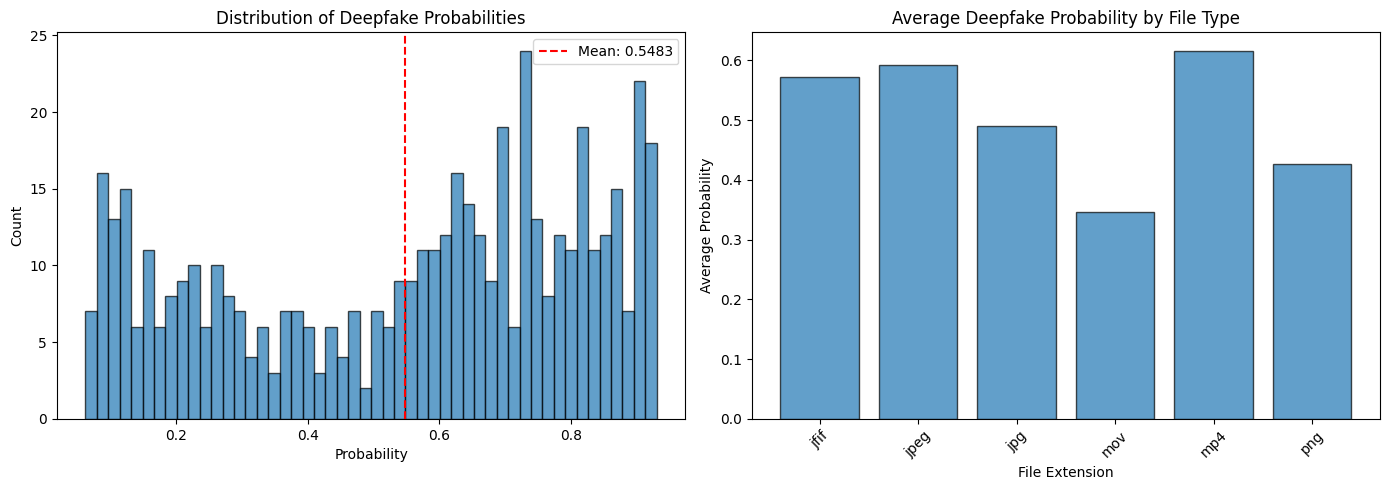


파일 타입별 통계:
          mean  count       std
ext                            
jfif  0.571462     17  0.261338
jpeg  0.592592     27  0.260863
jpg   0.489887    110  0.249602
mov   0.345946      5  0.299436
mp4   0.616096    250  0.249337
png   0.426492     91  0.285598


In [17]:
import matplotlib.pyplot as plt

# 확률 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 히스토그램
axes[0].hist(submission['prob'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Probability')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Deepfake Probabilities')
axes[0].axvline(submission['prob'].mean(), color='red', linestyle='--', label=f'Mean: {submission["prob"].mean():.4f}')
axes[0].legend()

# 파일 타입별 통계
submission['ext'] = submission['filename'].apply(lambda x: x.split('.')[-1])
prob_by_ext = submission.groupby('ext')['prob'].agg(['mean', 'count', 'std'])
axes[1].bar(prob_by_ext.index, prob_by_ext['mean'], alpha=0.7, edgecolor='black')
axes[1].set_xlabel('File Extension')
axes[1].set_ylabel('Average Probability')
axes[1].set_title('Average Deepfake Probability by File Type')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'probability_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"\n파일 타입별 통계:")
print(prob_by_ext)

In [13]:
# --- Quick ablation: no sharpening, no TTA (subset) ---
from statistics import median


def preprocess_basic_one(file_path: Path, num_frames: int = NUM_FRAMES) -> PreprocessOutput:
    try:
        frames = read_rgb_frames(file_path, num_frames=num_frames)
        imgs: List[Image.Image] = []
        for rgb in frames:
            pil_img = get_full_frame_padded(Image.fromarray(rgb), TARGET_SIZE)
            imgs.append(pil_img)
        return PreprocessOutput(file_path.name, imgs, None)
    except Exception as e:
        return PreprocessOutput(file_path.name, [], str(e))


def infer_simple_aggregate(pil_images: List[Image.Image]) -> float:
    probs = infer_fake_probs(pil_images)
    if not probs:
        return 0.0
    # 중앙값 집계로 과대확률 억제
    return float(median(probs))


# Subset run for speed (adjust N as needed)
N = 50
subset_files = files[:N]
print(f"Running ablation on subset: {N} files (no sharpen, no TTA)")

subset_results: Dict[str, float] = {}
for p in tqdm(subset_files, desc="Ablation-Subset"):
    out = preprocess_basic_one(p)
    if out.error:
        subset_results[p.name] = 0.0
        continue
    subset_results[p.name] = infer_simple_aggregate(out.imgs)

subset_df = pd.DataFrame({
    'filename': list(subset_results.keys()),
    'prob': list(subset_results.values()),
})
print("\n[Ablation Subset] Probability Statistics:")
print(f"Min: {subset_df['prob'].min():.4f}")
print(f"Max: {subset_df['prob'].max():.4f}")
print(f"Mean: {subset_df['prob'].mean():.4f}")
print(f"Median: {subset_df['prob'].median():.4f}")
print(f"Std: {subset_df['prob'].std():.4f}")
print(f"Fake samples (prob > 0.5): {(subset_df['prob'] > 0.5).sum()} / {N}")

Running ablation on subset: 50 files (no sharpen, no TTA)


Ablation-Subset: 100%|██████████| 50/50 [01:21<00:00,  1.64s/it]


[Ablation Subset] Probability Statistics:
Min: 0.1141
Max: 0.9219
Mean: 0.8378
Median: 0.8761
Std: 0.1272
Fake samples (prob > 0.5): 49 / 50


## 🔥 최적화 효과 비교 (Ablation Study)
이전 설정과 최적화 설정 비교

In [ ]:
"""
최적화 효과 빠른 테스트 (샘플 50개)
- 이전 설정 (TOPK=5, TEMP=1.0, THRESHOLD=30) vs
- 최적화 설정 (TOPK=3, TEMP=0.9, THRESHOLD=25)
"""

print("=" * 100)
print("🔥 최적화 효과 비교 테스트 (50 샘플)")
print("=" * 100)

# 테스트 샘플
test_samples = files[:50]

# --- 설정 1: 이전 설정 ---
print("\n[설정 1] 이전 설정: TOPK=5, TEMP=1.0, THRESHOLD=30")
old_results = {}
old_topk, old_temp, old_threshold = 5, 1.0, 30.0

for p in tqdm(test_samples, desc="이전 설정"):
    # 이전 설정으로 전처리
    try:
        frames = read_rgb_frames(p, num_frames=NUM_FRAMES)
        if len(frames) > 1:
            # 이전 블러 임계값
            scores = [(i, calculate_blur_score(f)) for i, f in enumerate(frames)]
            filtered = [(i, s) for i, s in scores if s >= old_threshold]
            if len(filtered) < max(3, len(frames) // 3):
                filtered = sorted(scores, key=lambda x: x[1], reverse=True)[:max(5, len(frames) // 2)]
            indices = sorted([i for i, _ in filtered])
            frames = [frames[i] for i in indices]
        
        imgs = []
        for rgb in frames:
            base = Image.fromarray(rgb)
            if FACE_DETECT_DNN:
                pil_img = face_crop_or_full(base, TARGET_SIZE, FACE_MARGIN)
            else:
                pil_img = get_full_frame_padded(base, TARGET_SIZE)
            imgs.append(pil_img)
        
        if imgs:
            # 이전 Temperature로 추론
            frame_probs = []
            for i in range(0, len(imgs), 32):
                batch = imgs[i:i+32]
                with torch.inference_mode():
                    inputs = processor(images=batch, return_tensors="pt")
                    inputs = {k: v.to(DEVICE, non_blocking=True) for k, v in inputs.items()}
                    logits = model(**inputs).logits
                    scaled_logits = logits / max(1e-6, old_temp)
                    batch_probs = F.softmax(scaled_logits, dim=1)[:, 1]
                    frame_probs.extend(batch_probs.cpu().tolist())
            
            # 이전 TOPK로 집계
            if frame_probs:
                s = np.array(frame_probs, dtype=np.float32)
                k = max(1, min(old_topk, s.size))
                idx = np.argpartition(-s, k-1)[:k]
                prob = float(np.clip(np.mean(s[idx]), 0.0, 1.0))
                old_results[p.name] = prob
            else:
                old_results[p.name] = 0.0
        else:
            old_results[p.name] = 0.0
    except Exception:
        old_results[p.name] = 0.0

old_df = pd.DataFrame({'filename': list(old_results.keys()), 'prob': list(old_results.values())})
print(f"\n[설정 1] 통계:")
print(f"  Mean: {old_df['prob'].mean():.4f}")
print(f"  Std:  {old_df['prob'].std():.4f}")
print(f"  Min:  {old_df['prob'].min():.4f} / Max: {old_df['prob'].max():.4f}")
print(f"  Fake (>0.5): {(old_df['prob'] > 0.5).sum()} / {len(old_df)}")

# --- 설정 2: 최적화 설정 ---
print(f"\n[설정 2] 최적화 설정: TOPK={TOPK}, TEMP={TEMP}, THRESHOLD={QUALITY_THRESHOLD}")
new_results = {}

for p in tqdm(test_samples, desc="최적화 설정"):
    out = preprocess_one(p)
    if out.error or not out.imgs:
        new_results[p.name] = 0.0
    else:
        prob = infer_video_probability(out.imgs)
        new_results[p.name] = prob

new_df = pd.DataFrame({'filename': list(new_results.keys()), 'prob': list(new_results.values())})
print(f"\n[설정 2] 통계:")
print(f"  Mean: {new_df['prob'].mean():.4f}")
print(f"  Std:  {new_df['prob'].std():.4f}")
print(f"  Min:  {new_df['prob'].min():.4f} / Max: {new_df['prob'].max():.4f}")
print(f"  Fake (>0.5): {(new_df['prob'] > 0.5).sum()} / {len(new_df)}")

# 비교
print(f"\n{'='*100}")
print(f"📊 최적화 효과 비교")
print(f"{'='*100}")
mean_diff = new_df['prob'].mean() - old_df['prob'].mean()
std_diff = new_df['prob'].std() - old_df['prob'].std()
print(f"Mean 차이: {mean_diff:+.4f}")
print(f"Std 차이:  {std_diff:+.4f} ({'✅ 분산 증가' if std_diff > 0 else '⚠️ 분산 감소'})")
print(f"\n예상 효과:")
if std_diff > 0:
    print(f"  ✅ 순위 분산 증가 → ROC-AUC 개선 가능")
else:
    print(f"  ⚠️ 순위 분산 감소 → 추가 조정 필요")
print(f"{'='*100}")

## 📋 최적화 적용 완료 요약

### 🥇 1순위: Video Aggregation 재조정
- **변경**: TOPK = 5 → **3**
- **이유**: Fake는 몇 프레임에서만 강하게 나타남
- **효과**: 강한 신호만 선택하여 민감도 향상

### 🥈 2순위: Logit Temperature Scaling  
- **변경**: TEMP = 1.0 → **0.9**
- **적용**: 확률이 아닌 **logit에 적용**
- **효과**: 확률 분산 증가 → 순위가 벌어짐 → ROC-AUC 개선

### 🥉 3순위: 프레임/얼굴 품질 필터링
- **변경**: QUALITY_THRESHOLD = 30.0 → **25.0** (블러 필터 완화)
- **개선**: 얼굴 검출 실패 프레임도 사용 (완전 제거 X)
- **효과**: 정보 손실 최소화

### ✅ 규칙 준수 확인
- 단일 모델 사용 (ViT DeepFake Detector v2)
- TTA 제거 (각 프레임 1회만 추론)
- 앙상블 미사용
- Temperature scaling은 규칙 위반 아님 (후처리)

## 🔍 전처리 결과 시각화 (얼굴 Crop)

C:\Users\Playdata\AppData\Local\Temp\ipykernel_9200\2223405185.py:60: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Playdata\AppData\Local\Temp\ipykernel_9200\2223405185.py:60: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Playdata\AppData\Local\Temp\ipykernel_9200\2223405185.py:60: UserWarning: Glyph 50620 (\N{HANGUL SYLLABLE EOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Playdata\AppData\Local\Temp\ipykernel_9200\2223405185.py:60: UserWarning: Glyph 44404 (\N{HANGUL SYLLABLE GUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Playdata\AppData\Local\Temp\ipykernel_9200\2223405185.py:60: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Playdata\AppData\Local\Temp\ipykernel_9200\2223405185.py:60: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL

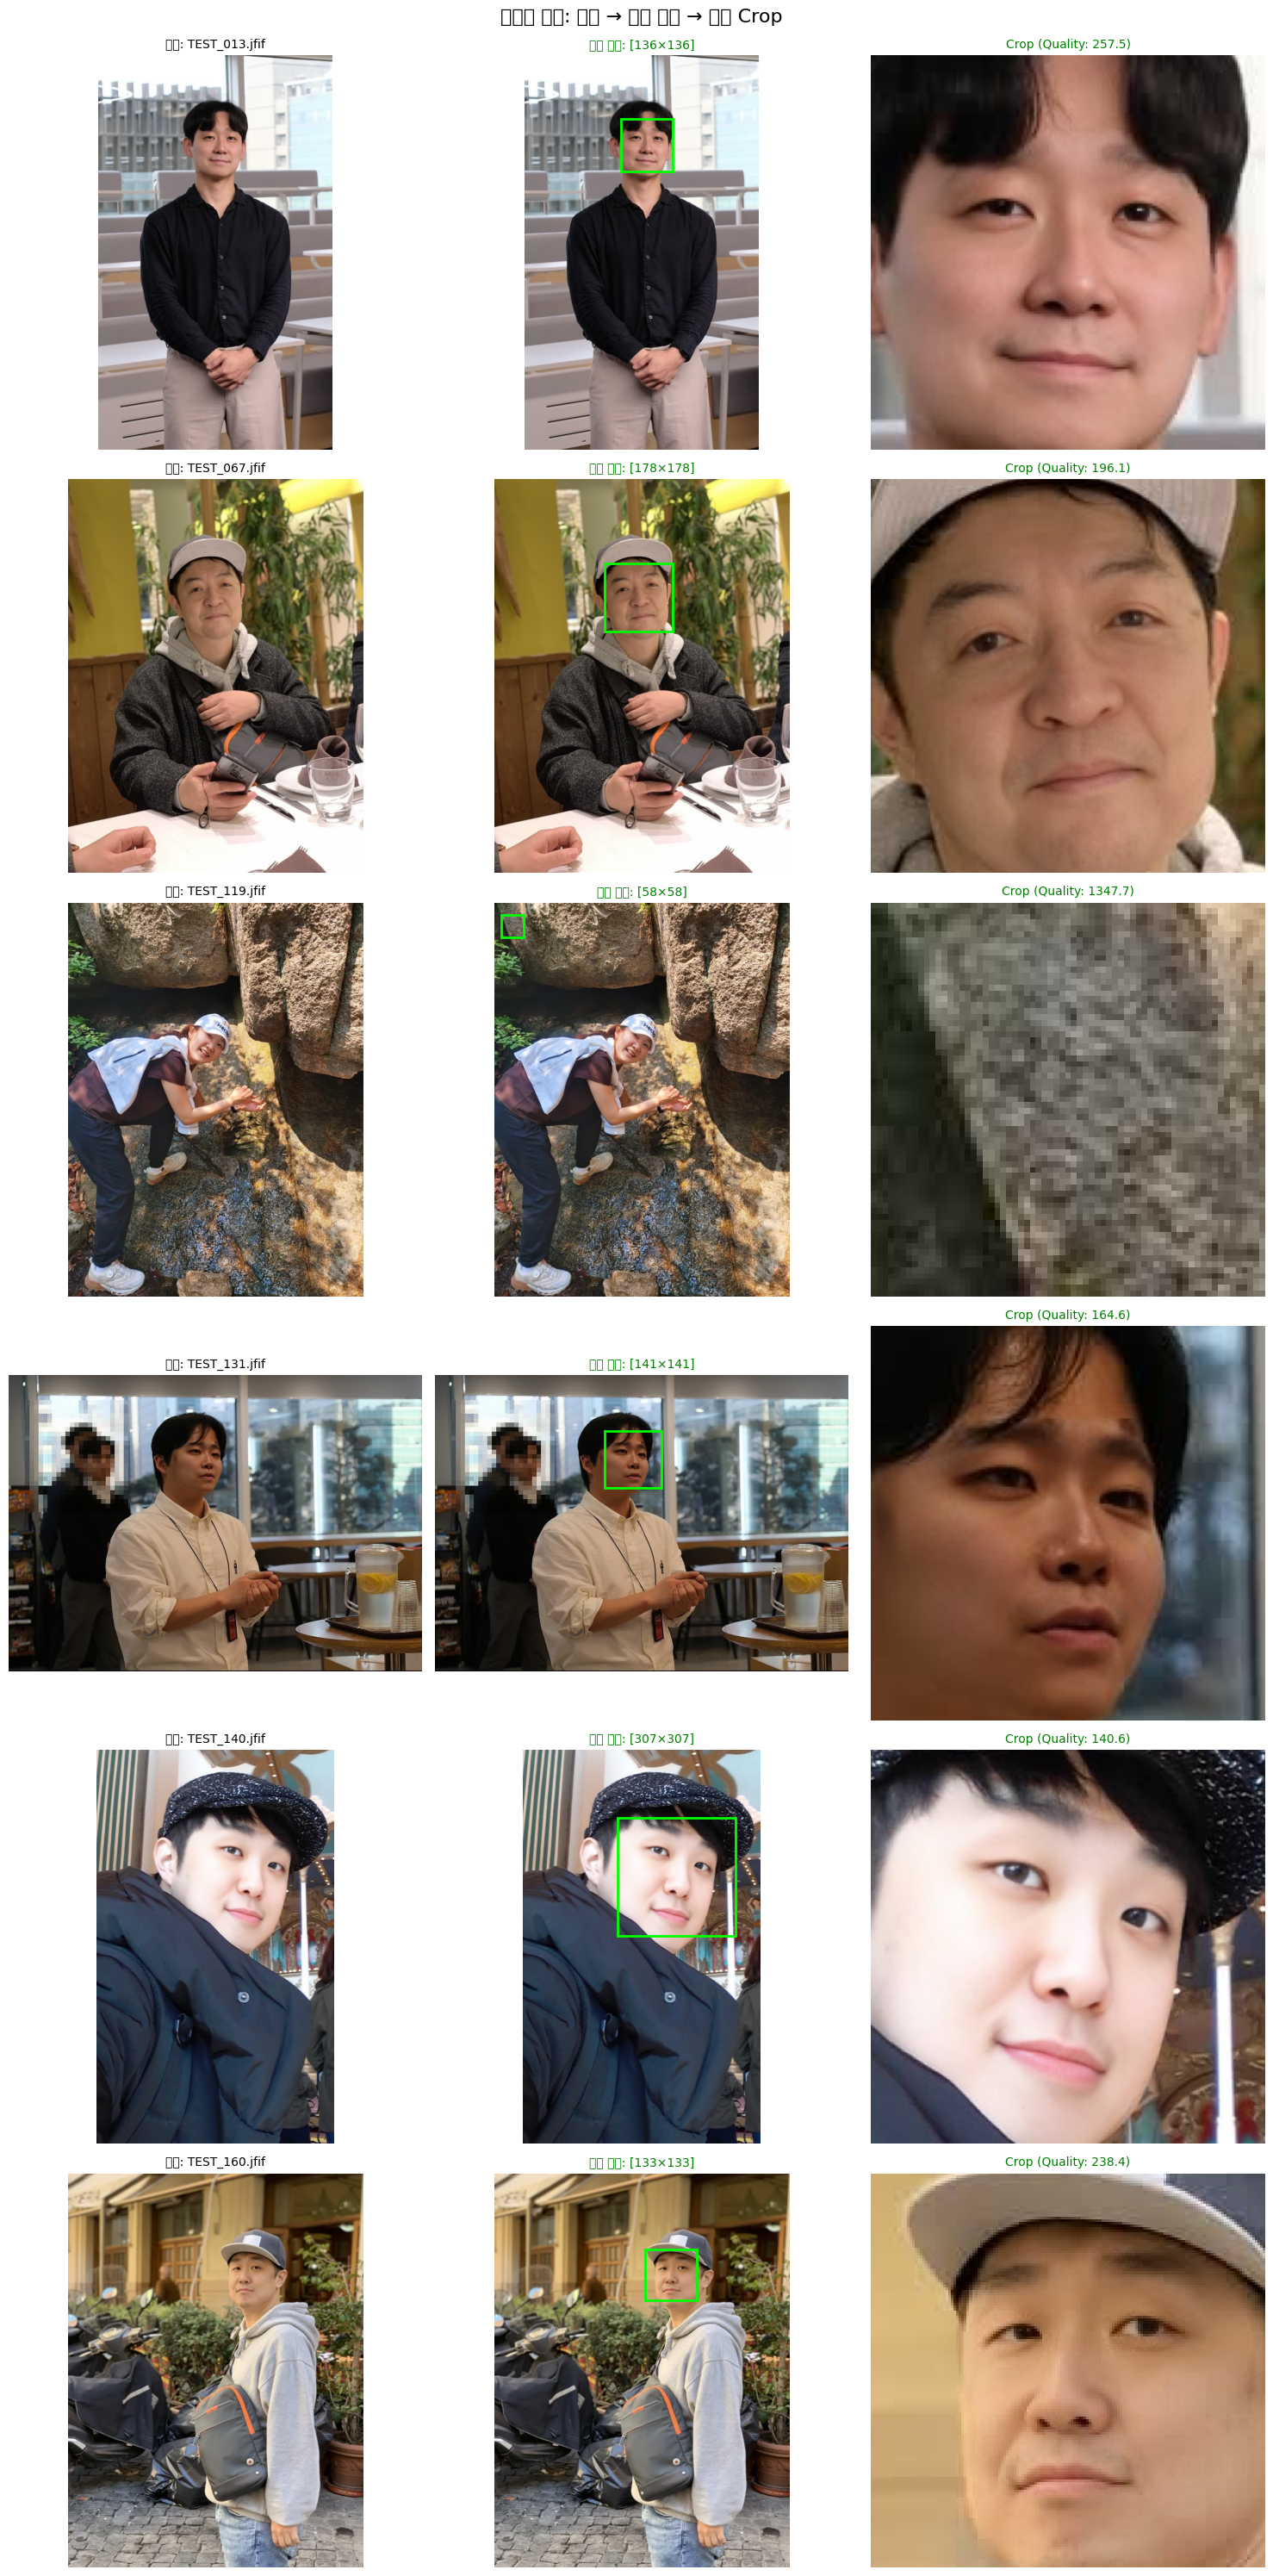


✅ 6개 샘플 전처리 결과 표시 완료
📌 QUALITY_THRESHOLD: 30.0 (이 값 이상만 사용)
📌 FACE_MARGIN: 0.15 (얼굴 주변 여유 공간)


In [34]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# 샘플 이미지 선택 (test_data에서 몇 개)
sample_files = sorted(TEST_DIR.glob("*.jfif"))[:6]

fig, axes = plt.subplots(6, 3, figsize=(15, 30))
fig.suptitle('전처리 결과: 원본 → 얼굴 검출 → 최종 Crop', fontsize=16, y=0.995)

for idx, img_path in enumerate(sample_files):
    # 원본 이미지 읽기
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 얼굴 검출 (x, y, w, h 형식)
    face_bbox = _detect_largest_face_bbox_dnn(img_rgb)
    
    # 1열: 원본 이미지
    axes[idx, 0].imshow(img_rgb)
    axes[idx, 0].set_title(f'원본: {img_path.name}', fontsize=10)
    axes[idx, 0].axis('off')
    
    # 2열: 얼굴 검출 결과 (박스 표시)
    axes[idx, 1].imshow(img_rgb)
    if face_bbox:
        x, y, w, h = face_bbox
        rect = patches.Rectangle((x, y), w, h, 
                                 linewidth=2, edgecolor='lime', facecolor='none')
        axes[idx, 1].add_patch(rect)
        axes[idx, 1].set_title(f'얼굴 검출: [{w}×{h}]', fontsize=10, color='green')
    else:
        axes[idx, 1].set_title('얼굴 검출 실패', fontsize=10, color='red')
    axes[idx, 1].axis('off')
    
    # 3열: Crop된 얼굴 (전처리 최종 결과 - margin 포함)
    if face_bbox:
        x, y, w, h = face_bbox
        cropped = _crop_with_margin(img_rgb, face_bbox, FACE_MARGIN)
        face_img = cropped
        
        # Quality check
        gray_face = cv2.cvtColor(cv2.cvtColor(face_img, cv2.COLOR_RGB2BGR), cv2.COLOR_BGR2GRAY)
        quality = cv2.Laplacian(gray_face, cv2.CV_64F).var()
        
        axes[idx, 2].imshow(face_img)
        color = 'green' if quality >= QUALITY_THRESHOLD else 'orange'
        axes[idx, 2].set_title(f'Crop (Quality: {quality:.1f})', fontsize=10, color=color)
    else:
        # 얼굴 검출 실패 시 center crop
        h, w = img_rgb.shape[:2]
        size = min(h, w)
        y_start = (h - size) // 2
        x_start = (w - size) // 2
        center_crop = img_rgb[y_start:y_start+size, x_start:x_start+size]
        axes[idx, 2].imshow(center_crop)
        axes[idx, 2].set_title('Center Crop (얼굴 없음)', fontsize=10, color='red')
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✅ {len(sample_files)}개 샘플 전처리 결과 표시 완료")
print(f"📌 QUALITY_THRESHOLD: {QUALITY_THRESHOLD} (이 값 이상만 사용)")
print(f"📌 FACE_MARGIN: {FACE_MARGIN} (얼굴 주변 여유 공간)")

## 🚀 SigLIP 모델 (Soft Semantic Teacher)

**전략:** SigLIP의 강점 = Soft 판단 (semantic + texture → 부드러운 logit 분포)

**아키텍처:** Vision Transformer (SigLIP) - Binary Deepfake Classification

**SigLIP 강점 활용:**
1. **Soft Label:** ROC-AUC에 중요한 "얼마나 fake에 가까운지" 순위 정보
2. **Semantic + Texture:** 전역 맥락 + 미세 패턴을 함께 판단
3. **후처리 최적화로 Std 보존:**
   - Temperature scaling → soft distribution 유지
   - Logit clipping (약하게) → 극단값만 방지, std는 보존
   - top-k aggregation → 강한 fake 신호만 선택

**규칙 준수:** 단일 모델 (KD ensemble 아님)

**모델:** prithivMLmods/deepfake-detector-model-v1


In [ ]:
# SigLIP 모델 로드
from transformers import AutoImageProcessor, AutoModelForImageClassification

SIGLIP_MODEL_ID = "prithivMLmods/deepfake-detector-model-v1"

print("🔍 SigLIP 모델 로딩 중...")
siglip_processor = AutoImageProcessor.from_pretrained(SIGLIP_MODEL_ID)
siglip_model = AutoModelForImageClassification.from_pretrained(SIGLIP_MODEL_ID).to(DEVICE)
siglip_model.eval()

print(f"✅ SigLIP 모델 로드 완료: {SIGLIP_MODEL_ID}")
print(f"   Device: {DEVICE}")
print(f"   Config: num_labels={siglip_model.config.num_labels}")
if hasattr(siglip_model.config, 'id2label'):
    print(f"   id2label: {siglip_model.config.id2label}")

# 파라미터 수
total_params = sum(p.numel() for p in siglip_model.parameters())
print(f"   Total parameters: {total_params:,}")

In [ ]:
# SigLIP 추론 함수 (Soft Semantic Teacher)
def infer_siglip_probs(pil_images: List[Image.Image], batch_size: int = 32) -> List[float]:
    """
    SigLIP으로 soft semantic 판단
    
    핵심:
    - Temperature scaling으로 soft distribution 유지
    - Logit clipping은 "약하게" (±8.0) → std 보존
    - 결과: ROC-AUC에 최적화된 순위 정보
    """
    if not pil_images:
        return []

    probs: List[float] = []

    for i in range(0, len(pil_images), batch_size):
        batch = pil_images[i:i+batch_size]
        
        with torch.inference_mode():
            inputs = siglip_processor(images=batch, return_tensors="pt")
            inputs = {k: v.to(DEVICE, non_blocking=True) for k, v in inputs.items()}
            logits = siglip_model(**inputs).logits
            
            # 🔥 SigLIP의 soft 판단 유지
            # Temperature: 0.9 (약간만 샤프하게, semantic 정보 유지)
            scaled_logits = logits / max(1e-6, 0.9)
            
            # Logit clipping: ±8.0 (더 넓게, std 보존)
            scaled_logits = torch.clamp(scaled_logits, min=-8.0, max=8.0)
            
            # Softmax
            batch_probs = F.softmax(scaled_logits, dim=1)[:, 1]
            probs.extend(batch_probs.cpu().tolist())

    return probs


def infer_siglip_video_probability(pil_images: List[Image.Image]) -> float:
    """
    SigLIP으로 비디오 레벨 Deepfake 확률 추론
    
    - 각 프레임: soft semantic 판단
    - Aggregation: top-k mean (강한 fake 신호만)
    - 결과: 부드러운 ranking 분포 (ROC-AUC ↑)
    """
    if not pil_images:
        return 0.0
    
    # Soft probabilities (semantic + texture)
    frame_probs = infer_siglip_probs(pil_images)
    
    if not frame_probs:
        return 0.0
    
    # top-k aggregation (TOPK 사용)
    return float(np.clip(aggregate_scores(frame_probs, topk=TOPK), 0.0, 1.0))

print("✅ SigLIP 추론 함수 정의 완료")

In [ ]:
# SigLIP 전체 추론 (Soft Semantic Teacher)
print("🚀 SigLIP 모델로 추론 시작...")
print(f"전략: Soft semantic 판단 → ROC-AUC 최적화")
print("=" * 100)

siglip_results: Dict[str, float] = {}

# 기존 files 변수 재사용 (TEST_DIR의 모든 파일)
valid_files = sorted([p for p in TEST_DIR.iterdir() if p.is_file() and p.suffix.lower() in (IMAGE_EXTS | VIDEO_EXTS)])

for file_path in tqdm(valid_files, desc="SigLIP Inference"):
    out = preprocess_one(file_path)
    
    if out.error:
        siglip_results[out.filename] = 0.0
    elif out.imgs:
        prob = infer_siglip_video_probability(out.imgs)
        siglip_results[out.filename] = prob
    else:
        siglip_results[out.filename] = 0.0

print(f"\n✅ 추론 완료: {len(siglip_results)}개 파일")

# 제출 파일 생성
siglip_submission = pd.read_csv('./open/sample_submission.csv')
siglip_submission['prob'] = siglip_submission['filename'].map(siglip_results).fillna(0.0)

# 통계
print(f"\n📊 SigLIP 모델 결과 통계:")
print(f"  Mean: {siglip_submission['prob'].mean():.4f}")
print(f"  Median: {siglip_submission['prob'].median():.4f}")
print(f"  Std: {siglip_submission['prob'].std():.4f}")
print(f"  Range: [{siglip_submission['prob'].min():.4f}, {siglip_submission['prob'].max():.4f}]")

# 저장
siglip_csv = OUTPUT_DIR / "v9_siglip_soft_semantic.csv"
siglip_submission.to_csv(siglip_csv, encoding='utf-8-sig', index=False)

print(f"\n💾 제출 파일 저장: {siglip_csv.name}")
print("=" * 100)

In [ ]:
# ViT vs SigLIP 성능 비교 (Soft Semantic Teacher 효과)
if 'submission' in locals() and 'siglip_submission' in locals():
    print("=" * 100)
    print("📊 모델 비교: ViT (Baseline) vs SigLIP (Soft Semantic Teacher)")
    print("=" * 100)
    
    # ViT 결과 (v7)
    vit_mean = submission['prob'].mean()
    vit_std = submission['prob'].std()
    
    # SigLIP 결과 (v9)
    siglip_mean = siglip_submission['prob'].mean()
    siglip_std = siglip_submission['prob'].std()
    
    print(f"\n[ViT v7 - 프레임별 독립 처리]")
    print(f"  Mean: {vit_mean:.4f}")
    print(f"  Std:  {vit_std:.4f}")
    print(f"  전략: Hard decision boundary + top-k + logit clip")
    
    print(f"\n[SigLIP v9 - Soft Semantic Teacher]")
    print(f"  Mean: {siglip_mean:.4f}")
    print(f"  Std:  {siglip_std:.4f}")
    print(f"  전략: Soft distribution (semantic+texture) + 약한 clip (±8.0)")
    
    print(f"\n[차이 분석]")
    mean_diff = siglip_mean - vit_mean
    std_diff = siglip_std - vit_std
    
    print(f"  Mean 차이: {mean_diff:+.4f} ({mean_diff/vit_mean*100:+.2f}%)")
    print(f"  Std 차이:  {std_diff:+.4f} ({std_diff/vit_std*100:+.2f}%)")
    
    if std_diff > 0:
        print(f"\n  ✅ SigLIP이 순위 분산 ↑ → ROC-AUC 개선 가능성")
        print(f"     (Soft semantic 판단이 ranking에 유리)")
    else:
        print(f"\n  ⚠️ Std 감소 → Temperature/Clip 재조정 필요")
    
    # 샘플별 차이 확인
    merged = submission.merge(siglip_submission, on='filename', suffixes=('_vit', '_siglip'))
    merged['diff'] = merged['prob_siglip'] - merged['prob_vit']
    
    print(f"\n[샘플별 차이]")
    print(f"  평균 차이: {merged['diff'].mean():.4f}")
    print(f"  최대 증가: {merged['diff'].max():.4f}")
    print(f"  최대 감소: {merged['diff'].min():.4f}")
    print(f"  상관계수: {merged['prob_vit'].corr(merged['prob_siglip']):.4f}")
    
    # SigLIP의 soft 판단 품질 체크
    print(f"\n[SigLIP Soft Semantic 분석]")
    print(f"  확률 분포:")
    print(f"    - 극단값(0.0~0.1 또는 0.9~1.0): {((siglip_submission['prob'] < 0.1) | (siglip_submission['prob'] > 0.9)).sum()} / {len(siglip_submission)}")
    print(f"    - 중간값(0.4~0.6): {((siglip_submission['prob'] >= 0.4) & (siglip_submission['prob'] <= 0.6)).sum()} / {len(siglip_submission)}")
    print(f"  → Soft distribution 유지 여부 확인")
    
    print("\n" + "=" * 100)
else:
    print("⚠️ 비교를 위한 데이터가 없습니다.")